---

# Georgios_Ioannou


## Copyright © 2023 by Georgios Ioannou


---

<h1 align="center"> Text Emotion System Sentiment Analysis </h1>
<h2 align="center"> TESSA </h2>

In this notebook, we will be classifying emotion based on text documents. The dataset we will be using is called:

<p style="text-align: center;"><a href="https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp">Emotions Dataset for NLP</a></p>


---

<h2 align="center"> Remember our main steps motto "ISBE" </h2>

<h3 align="center"> Main Steps when building a Machine Learning Model </h3>

1. **I** - `Inspect and explore data`
2. **S** - `Select and engineer features`
3. **B** - `Build and train model`
4. **E** - `Evaluate model`


---

<h2 align='center'> GPU Information </h2>


In [1]:
!nvidia-smi

Wed Dec 20 04:07:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

<h2 align='center'> Libraries </h2>


In [3]:
# Import libraries.

# Use inline so our visualizations display in notebook.


%matplotlib inline


import matplotlib.pyplot as plt   # Data visualization.
import nltk                       # Natural Language Processing.
import numpy as np                # Data wrangling.
import os                         # Manipulate operating system interfaces.
import pandas as pd               # Data handling.
pd.set_option('display.max_colwidth', None)
import pickle                     # Python object serialization.
import plotly.express as px       # Data visualization
import plotly.graph_objects as go # Data visualization
import re                         # Regular expression operations.
import seaborn as sns             # Data visualization.
import subprocess                 # To download nltk wordnet in Kaggle.
sns.set()
import warnings                   # Ignore all warnings.
warnings.filterwarnings('ignore')


from nltk.stem import WordNetLemmatizer # Lemmatize using WordNet's built-in morphy function.
from nltk.stem import                   # Remove morphological affixes from words, leaving only the word stem.
from nltk.corpus import stopwords       # Remove stopwaords.
from nltk import word_tokenize          # Tokenize.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, multilabel_confusion_matrix, precision_score, recall_score # Evaluation metrics.
from sklearn.model_selection import train_test_split     # Eplit data in training/validating/testing.
from sklearn.preprocessing import LabelEncoder           # Encode target labels with value between 0 and n_classes-1.
from tensorflow.keras.callbacks import EarlyStopping     # Stop training when a monitored metric has stopped improving.
from tensorflow.keras.callbacks import ReduceLROnPlateau # Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, LSTM, MaxPooling1D # Keras layers API.
from tensorflow.keras.models import Sequential # Sequential model.
from tensorflow.keras.optimizers import Adam   # Adam optimizer.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Transformsa list of sequences into a 2D Numpy array.
from tensorflow.keras.preprocessing.text import Tokenizer         # Vectorize a text corpus.
from tensorflow.keras.utils import plot_model                     # Visualize the model and save it.
from tensorflow.keras.utils import to_categorical                 # Converts a class vector (integers) to binary class matrix.

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


True

---

## #1 Inspect And Explore Data


### 1.3.4 Merge All Three Dataframes To One Dataframe


In [13]:
# Combined Pandas Dataframe.

combined_df = pd.concat(
    [
        train_df,
        val_df,
        test_df,
    ],
    axis=0,
)

# Sanity check.

print("Sanity Check")
print("------------")

print("combined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Check for null values per column.

print("Null Values Per Column")
print("----------------------")

print("combined_df.isnull().sum() =")
print(combined_df.isnull().sum(), "\n")

# Check for null values in the whole combined Pandas dataframe.

print("Null Values In The Whole Combined Pandas Dataframe")
print("--------------------------------------------------")

print("combined_df.isnull().sum().sum() = ", combined_df.isnull().sum().sum(), "\n")

print("*" * 100)

# Check for duplicate rows in the combined Pandas dataframe.

print("Duplicate Rows")
print("--------------")

duplicates = combined_df.duplicated()
print("duplicates.sum() =", duplicates.sum())
print("Duplicate Rows   =", end="")
print(combined_df[duplicates])

# Drop duplicate rows.

combined_df = combined_df.drop_duplicates()

# Sanity check.

print("\combined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Check for duplicate documents in the combined Pandas dataframe.
# (i.e. Documents that have more than one emotion attached to them.)
# Each document must have one and only one emotion.
# Keep only th first occurence of such a document.

# Check for duplicate entries in the 'document' column of the
# combined Pandas dataframe and returns a boolean Series.
# The boolean Series is stored in the 'duplicates' variable.

print("Duplicate Documents")
print("-------------------")

duplicates = combined_df.duplicated(subset="document")

# Print the length of the 'duplicates' boolean Series,
# which represents the number of duplicate 'document' entries.

print("len(combined_df[duplicates]) =", len(combined_df[duplicates]))

# Print the rows of the combined Pandas dataframe where the 'document' entry is a duplicate.

print(combined_df[duplicates])

# Remove the duplicate entries from the combined Pandas dataframe.
# The 'subset' parameter is used to specify the column to check for duplicates.

combined_df = combined_df.drop_duplicates(subset="document")

# Sanity check.

print("\ncombined_df.shape =", combined_df.shape, "\n")

print("*" * 100)

# Display the six unique emotions sorted in ascending order.

print("Classes and Value Counts")
print("------------------------")

print("Unique emotions =", sorted(combined_df["emotion"].unique()), "\n")
print("# of Unique emotions =", len(combined_df["emotion"].unique()), "\n")
print("# of Unique documents = ", len(combined_df["document"].unique()), "\n")

# Display the value count for each emotion.

print(combined_df.emotion.value_counts(), "\n")

print(
    combined_df.emotion.value_counts(), combined_df.emotion.value_counts(normalize=True)
)
print("*" * 100)

# This is the indexing that will be used for Label Encoding at a later stage.

print("Label Encoding")
print("--------------")

print("0=anger, 1=fear, 2=joy, 3=love, 4=sadness, 5=surprise\n")

print("*" * 100)

combined_df

Sanity Check
------------
combined_df.shape = (19967, 2) 

****************************************************************************************************
Null Values Per Column
----------------------
combined_df.isnull().sum() =
document    0
emotion     0
dtype: int64 

Null Values In The Whole Combined Pandas Dataframe
--------------------------------------------------
combined_df.isnull().sum().sum() =  0 

****************************************************************************************************
Duplicate Rows
--------------
duplicates.sum() = 0
Duplicate Rows   =Empty DataFrame
Columns: [document, emotion]
Index: []
\combined_df.shape = (19967, 2) 

****************************************************************************************************
Duplicate Documents
-------------------
len(combined_df[duplicates]) = 19
                                                                                                                                                  

,document,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
1995,i just keep feeling like someone is being unkind to me and doing me wrong and then all i can think of doing is to get back at them and the people they are close to,anger
1996,im feeling a little cranky negative after this doctors appointment,anger
1997,i feel that i am useful to my people and that gives me a great feeling of achievement,joy
1998,im feeling more comfortable with derby i feel as though i can start to step out my shell,joy


#### 1.3.4.1 Display A Document For Each And Every Emotion


In [14]:
# Group the combined_df Pandas dataframe by 'emotion'.

grouped_df = combined_df.groupby("emotion")

# For each group, randomly select one document.

sampled_df = grouped_df.sample(n=1)

# Display the sampled dataframe.

sampled_df

,document,emotion
1339,i have rarely left a meeting feeling more angry and upset,anger
477,i feel so helpless knowing i cant protect them and i worry about the others now,fear
481,i love sliding down on a nice big throbbing cock and feeling what my gorgeous body does to a man,joy
15525,i sense and keeps catching my attention is the feeling of the beloved s love pouring out of and through me touching those i encounter in a palpably strong way,love
8846,i feel so weepy like any moment i could just burst into tears,sadness
9609,i found the art at the other side of all i feel very impressed with my work,surprise


#### 1.3.4.2 Bar Chart And Pie Chart Of The Unique Emotions


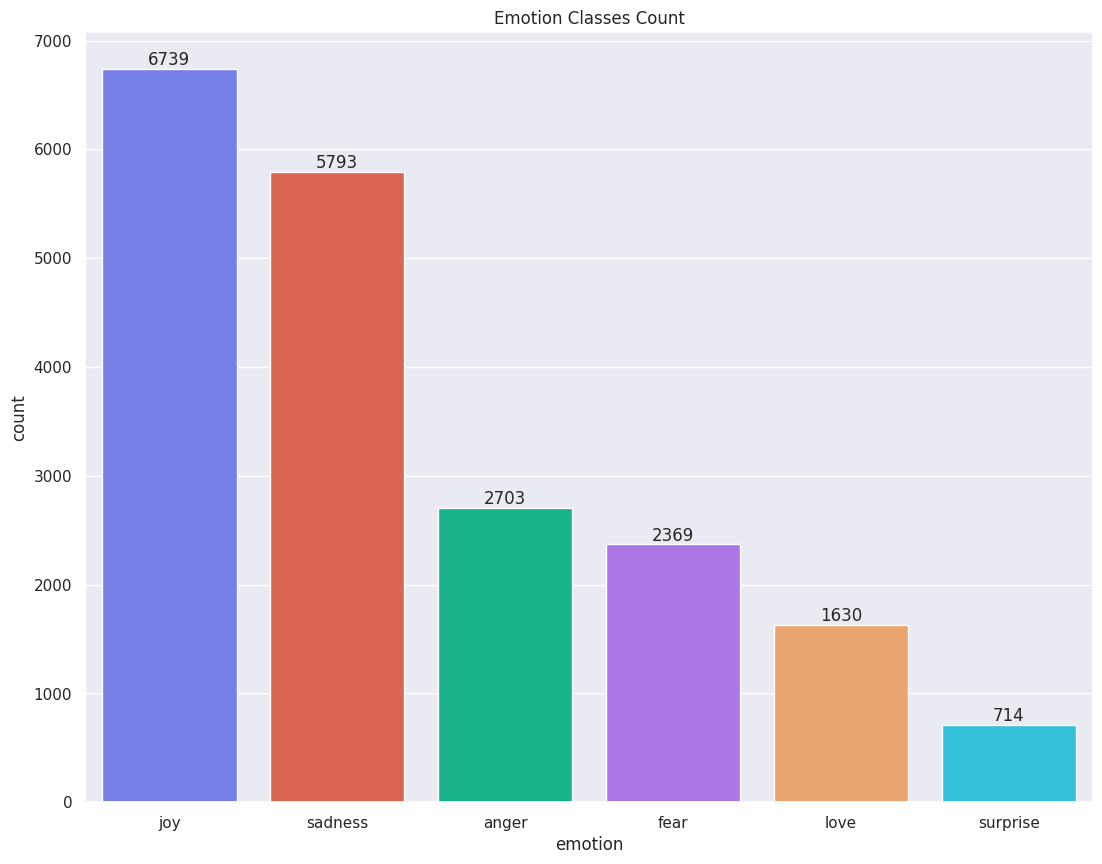

In [15]:
# Set the size of the figure to be 13x10.

plt.figure(figsize=(13, 10))

# Set the title of the figure to be 'Emotion Classes Count'.

plt.title("Emotion Classes Count")

# Create a count plot of the 'emotion' column in the combined Pandas dataframe.
# The 'order' parameter is used to specify the order of the bars.
# The bars are ordered based on the index of the 'emotion' column's value counts.
# The 'palette' parameter is used to specify the colors of the bars.

ax = sns.countplot(
    data=combined_df,
    x="emotion",
    order=combined_df["emotion"].value_counts().index,
    palette=["#636efa", "#ef553b", "#00cc96", "#ab63fa", "#ffa15a", "#19d3f3"],
)

# Add labels to the bars in the plot. The labels are the counts of each emotion.

ax.bar_label(ax.containers[0])

# Display the figure.

plt.show()

In [16]:
# Create a new Pandas dataframe that contains the 'emotion' column and its corresponding counts.
# The 'reset_index()' function is used to reset the index of the Pandas dataframe.
# The result is then stored in the 'emotion_counts' variable.

emotion_counts = combined_df["emotion"].value_counts().reset_index()

# Rename the columns of the emotion_counts Pandas dataframe to 'emotion' and 'count'.

emotion_counts.columns = ["emotion", "count"]

# Create a count plot of the emotion_counts Pandas dataframe.
# The 'x'      parameter is used to specify the column to plot on the x-axis, which is 'emotion'.
# The 'y'      parameter is used to specify the column to plot on the y-axis, which is 'count'.
# The 'color'  parameter is used to specify the column to use for the color of the bars, which is 'emotion'.
# The 'labels' parameter is used to specify the labels for the x-axis and y-axis.
# The 'title'  parameter is used to specify the title of the plot.

fig = px.bar(
    data_frame=emotion_counts,
    x="emotion",
    y="count",
    color="emotion",
    labels={"x": "emotion", "y": "count"},
    title="Emotion Classes Count",
)

# Displays the figure.

fig.show()

In [17]:
# Get the count of unique values in the 'emotion' column of the combined_df Pandas dataframe.

combined_df["emotion"].value_counts()

# Get the index of the value counts, which are the unique emotion values.

labels = combined_df["emotion"].value_counts().index

# Get` the values of the value counts, which are the counts of each emotion.

values = combined_df["emotion"].value_counts().values

# Define a list of colors to be used for the pie chart.

colors = [
    "#636efa",
    "#ef553b",
    "#00cc96",
    "#ab63fa",
    "#ffa15a",
    "#19d3f3",
    "#ff6692",
    "#b5e87f",
]

# Create a pie chart using the 'labels', 'values', and 'colors'.
# The 'textinfo'               parameter is set to 'label+percent' to display the labels and the percentage of each slice in the pie chart.
# The 'insidetextorientation' parameter is set to 'radial' to orient the labels radially.
# The 'marker'                parameter is used to set the colors of the slices.

fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            textinfo="label+percent",
            insidetextorientation="radial",
            marker=dict(colors=colors),
        )
    ]
)

# Set the title of the pie chart.

fig.update_layout(title="Emotion Classes Counts")

# Display the figure.

fig.show()

#### 1.3.4.3 Visualize Document Length (KDE Plot)


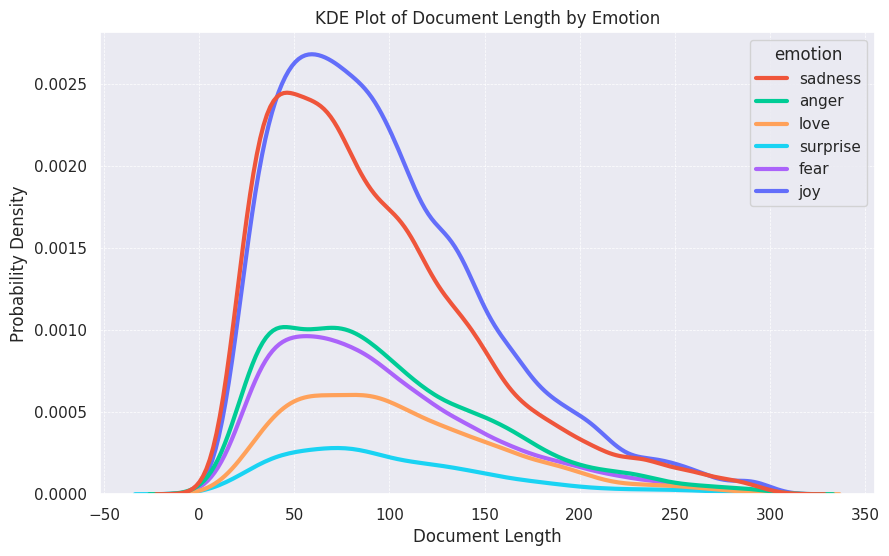

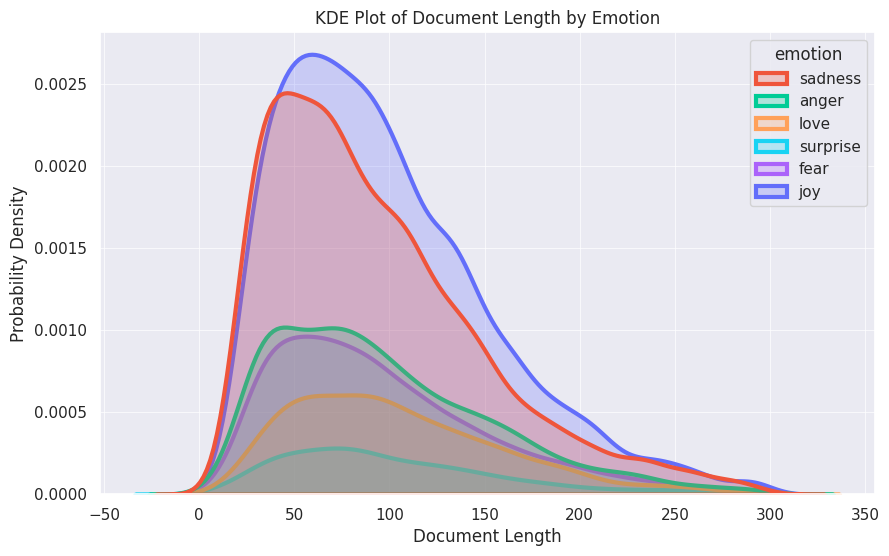

In [18]:
# Create a new column in the combined_df Pandas dataframe called document_length.
#  It is using the apply function to apply the built-in Python function len to
# each value in the document column of the dataframe.
# This calculates the length of each document.

combined_df["document_length"] = combined_df["document"].apply(len)

# First KDE plot.

# NOTE: First and Second KDE plots are the same.
#       The only difference is that the second KDE plot has shade.

fig, ax = plt.subplots(figsize=(10, 6))

# Create a KDE plot.
# The x-axis represents the document_length.
# The y-axis represents the probability density.
# The hue parameter is used to color the plot based on the emotion column in the Pandas dataframe.
# The palette parameter is used to specify the colors for the different emotions

sns.kdeplot(
    x=combined_df["document_length"],
    hue=combined_df["emotion"],
    palette=["#ef553b", "#00cc96", "#ffa15a", "#19d3f3", "#ab63fa", "#636efa"],
    linewidth=3,
    ax=ax,
)

# Set title and labels for the KDE plot.

ax.grid(True, linestyle="--", linewidth=0.5)
ax.set_title("KDE Plot of Document Length by Emotion")
ax.set_xlabel("Document Length")
ax.set_ylabel("Probability Density")

# Display the KDE plot.

plt.show()

# Second KDE plot.

# NOTE: First and Second KDE plots are the same.
#       The only difference is that the second KDE plot has shade.

fig, ax = plt.subplots(figsize=(10, 6))

# Create a KDE plot.
# The x-axis represents the document_length.
# The y-axis represents the probability density.
# The hue parameter is used to color the plot based on the emotion column in the Pandas dataframe.
# The palette parameter is used to specify the colors for the different emotions

sns.kdeplot(
    x=combined_df["document_length"],
    hue=combined_df["emotion"],
    palette=["#ef553b", "#00cc96", "#ffa15a", "#19d3f3", "#ab63fa", "#636efa"],
    linewidth=3,
    shade=True,
    ax=ax,
)

# Set title and labels for the KDE plot.

ax.grid(True, linewidth=0.5)
ax.set_title("KDE Plot of Document Length by Emotion")
ax.set_xlabel("Document Length")
ax.set_ylabel("Probability Density")

# Display the KDE plot.

plt.show()

#### 1.3.4.4 Descriptive Statistics For Document Length


In [19]:
# Generate descriptive statistics.

combined_df[["document_length"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
document_length,19948.0,96.700822,55.799681,7.0,53.0,86.0,129.0,300.0


#### 1.3.4.5 Histogram For Document Length Count


In [20]:
# Create the histogram.

fig = px.histogram(combined_df, x="document_length")

# Add title to the histogram.

fig.update_layout(title="Document Length Count")

# Display the histogram.

fig.show()